In [1]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
from datetime import datetime
from tabulate import tabulate
import math
import random
import numpy as np
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
import concurrent.futures
import multiprocessing
import logging
from sklearn.ensemble import RandomForestClassifier
from docx import Document
import json
import os
from io import BytesIO
import copy
from Configuration import NSGAConfig
from Chromosome import Chromosome
from Fast_NSGAII import NSGAII


In [70]:
def select_features_rf(X, y, num_features=10):
    model = RandomForestClassifier()
    model.fit(X, y)
    feature_importances = model.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:]
    return selected_features

In [71]:
def fast_non_dominated_sort( population):
        fronts = [[]]
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = set()

            for q in population:
                if p.dominate(q):
                    p.dominated_solutions.add(q)
                elif q.dominate(p):
                    p.domination_count += 1

            if p.domination_count == 0:
                p.rank = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = i + 1
                        next_front.append(q)

            i += 1
            fronts.append(next_front)
        return fronts


In [72]:
# for sure values are not correct
def create_chromosome(row, num_features):
    values = np.random.randint(2, size=num_features)
    chromosome = Chromosome(values)
    chromosome.objectives = [row['Classification-error'], row['Solution-size']]
    return chromosome

In [73]:
def calc_true_pareto_front(U_PF_dataset_path, num_features):
    df = pd.read_csv(U_PF_dataset_path)
    population = df.apply(lambda row: create_chromosome(row, num_features), axis=1)
    fronts = fast_non_dominated_sort(population)
    objectives = [chromosome.objectives for chromosome in fronts[0]]
    return objectives

In [75]:
def run_nsga_on_dataset(dataset_name):
    num_objectives = 2
    dataset_path = "Datasets/" + dataset_name
    dp = DataProcessor(dataset_path)
    dp.load_data()
    config_file_path = "config.json"
    config_data = json.loads(json_string)
    config = NSGAConfig(config_file_path)
    config.config_data = config_data
#     config = NSGAConfig(config_file_path)
    population_size, Q, LP, igd_threshold, hv_threshold, no_improvement_limit, maxFEs = config.get_parameters(dataset_name)
    y = np.array(dp.dataset["LABEL"])
    X = np.array(dp.dataset.drop("LABEL", axis=1, inplace=False))
    selected_features = select_features_rf(X, y, num_features=100)    
    num_features = dp.num_features()
    U_PF_dataset_path = "union-pareto/"+ dataset_name
    true_pareto_front = calc_true_pareto_front(U_PF_dataset_path, num_features)    
    print("number of features: ", num_features)
   
    nsga2 = NSGAII(X, y, population_size, LP, num_features, true_pareto_front, selected_features, maxFEs, no_improvement_limit, igd_threshold, hv_threshold)
    current_solutions, igd_values, hypervolume_values = nsga2.nsga2()
    return current_solutions, igd_values, hypervolume_values

In [64]:
def plot_values(dataset_name, current_solutions, igd_values, hypervolume_values):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    x_values = [item.objectives[1] for item in current_solutions]
    y_values = [item.objectives[0] for item in current_solutions]
    plt.scatter(x_values, y_values, marker='o', color='b')
    plt.xlabel('Solution Size')
    plt.ylabel('Classification Error')
    plt.title(f'Final Pareto front for {dataset_name}')

    plt.subplot(1, 3, 2)
    plt.plot(igd_values, color='r', label=f'Mean: {np.mean(igd_values):.2f}\nStd: {np.std(igd_values):.2f}')
    plt.title('IGD')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(hypervolume_values, color='g', label=f'Mean: {np.mean(hypervolume_values):.2f}\nStd: {np.std(hypervolume_values):.2f}')
    plt.title('Hypervolume')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [65]:
def run_different_dataset(dataset_name):
    start_time = time.time()
    current_solutions, igd_values, hypervolume_values = run_nsga_on_dataset(dataset_name)
    generations.append(len(igd_values))
    end_time = time.time()
    elapsed_time = end_time - start_time
    duration_minutes = elapsed_time // 60
    elapsed_times.append(duration_minutes)  
    hv_mean.append(np.mean(hypervolume_values))
    igd_mean.append(np.mean(igd_values))
    hv_std.append(np.std(hypervolume_values))
    igd_std.append(np.std(igd_values))
    
    plot_values(dataset_name, current_solutions, igd_values, hypervolume_values)


In [66]:
datasets = ["DS02.csv", "DS04.csv", "DS05.csv" ,"DS07.csv", "DS08.csv", "DS10.csv"]

In [67]:
document_path = "table.docx"
doc = Document()
doc.add_heading('Run Result', 0)
doc.save(document_path)

number of features:  56
Evaluations: 2500, HV: 46.4074074074074, IGD: 0.3788426751433336
Evaluations: 5000, HV: 48.25925925925926, IGD: 0.22258546689283798
Evaluations: 7400, HV: 48.25925925925926, IGD: 0.22258546689283798
No improvement in the last 30 generations. Stopping the algorithm.


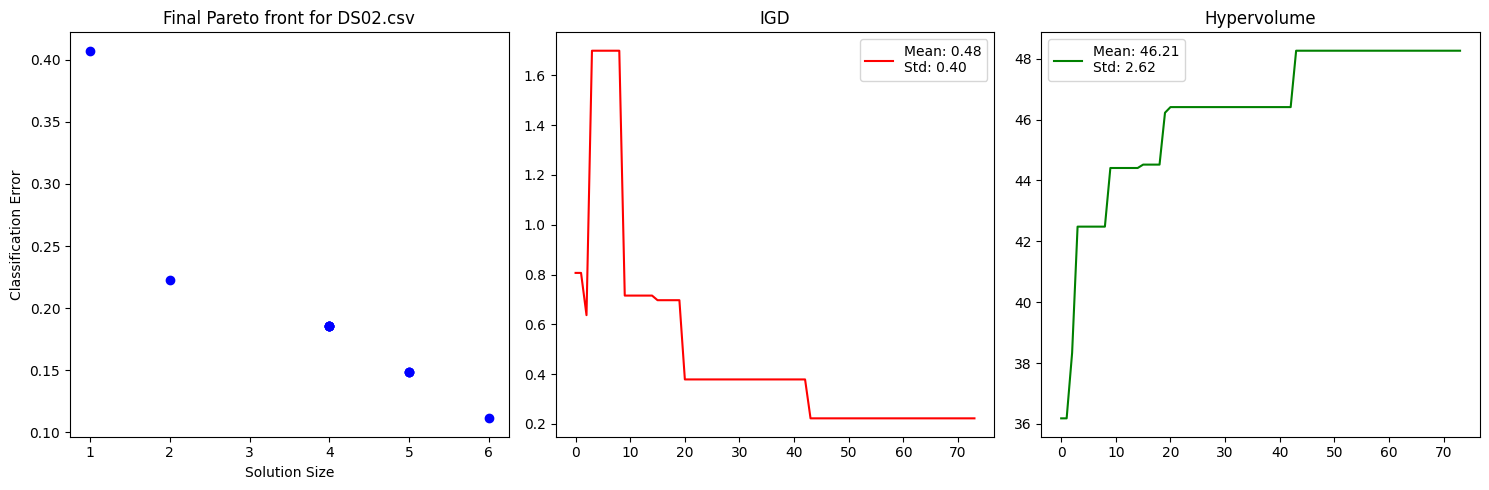

number of features:  56
Evaluations: 2500, HV: 44.51851851851852, IGD: 0.6970296706751585
Evaluations: 5000, HV: 48.18518518518518, IGD: 0.37884267514333353
Evaluations: 7500, HV: 48.18518518518518, IGD: 0.37884267514333353
Evaluations: 7800, HV: 48.18518518518518, IGD: 0.37884267514333353
No improvement in the last 30 generations. Stopping the algorithm.


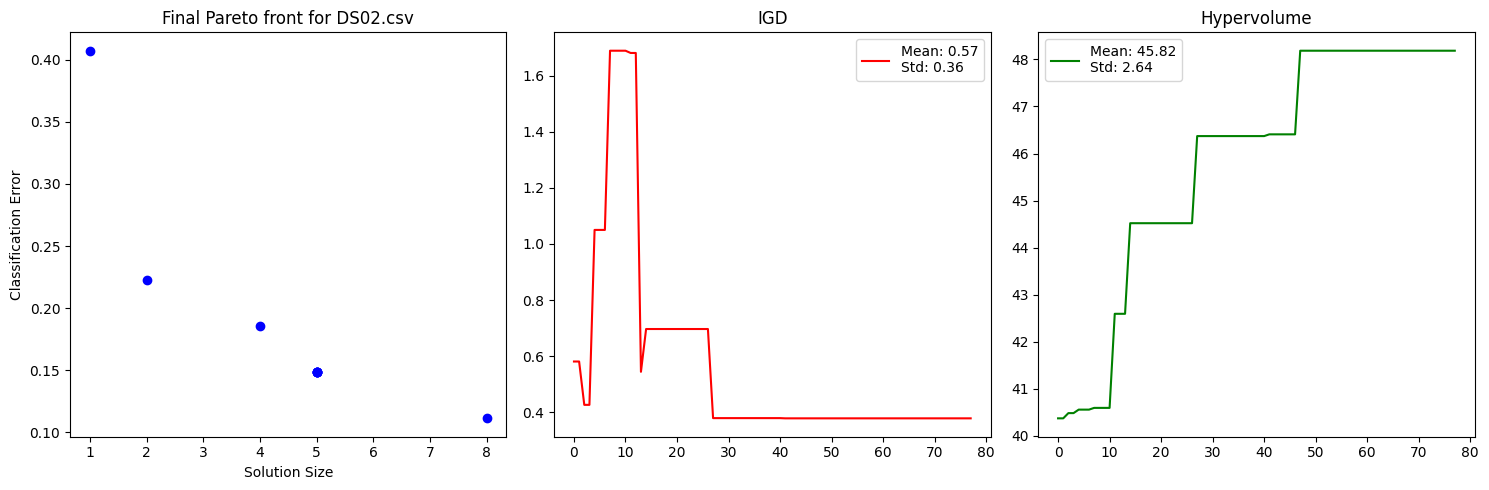

number of features:  56
Evaluations: 2500, HV: 46.33333333333333, IGD: 0.5304396326896876
Evaluations: 5000, HV: 48.222222222222214, IGD: 0.37831097395480207
Evaluations: 7500, HV: 48.25925925925926, IGD: 0.22258546689283795
Evaluations: 8600, HV: 48.25925925925926, IGD: 0.22258546689283795
No improvement in the last 30 generations. Stopping the algorithm.


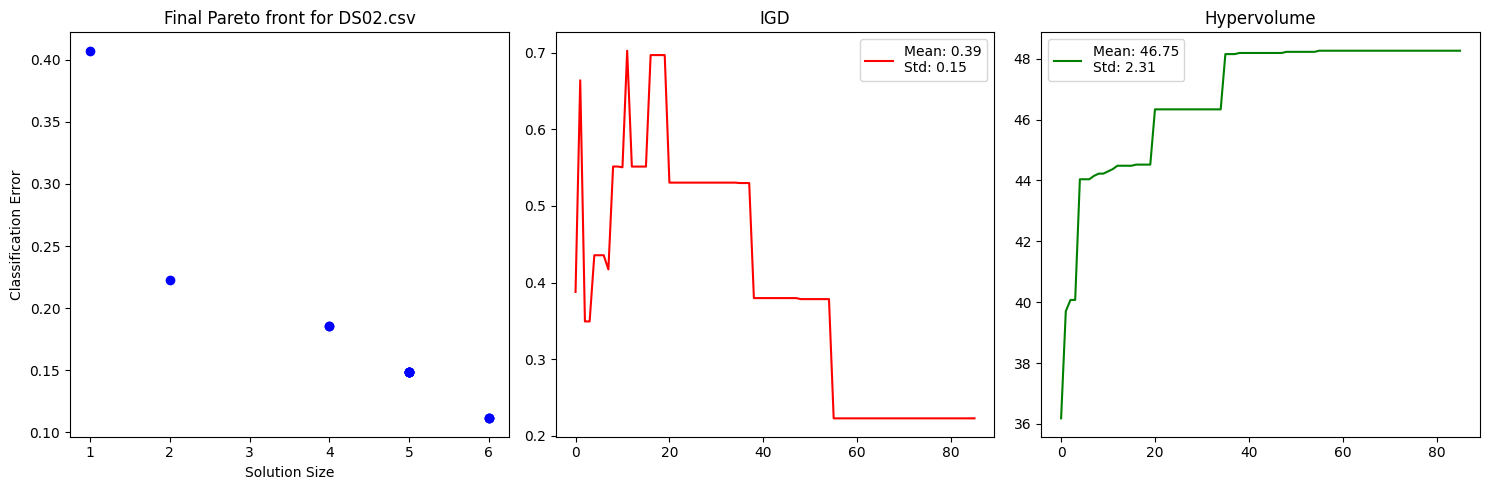

number of features:  56
Evaluations: 2500, HV: 46.4074074074074, IGD: 0.37884267514333353
Evaluations: 4800, HV: 46.4074074074074, IGD: 0.37884267514333353
No improvement in the last 30 generations. Stopping the algorithm.


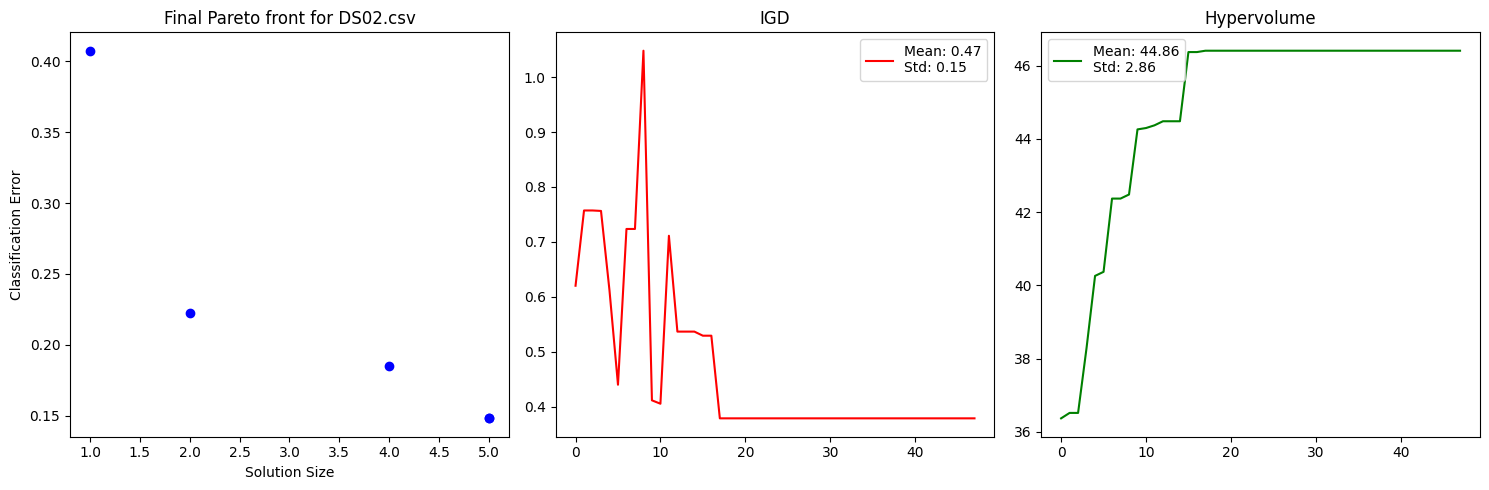

number of features:  56
Evaluations: 2500, HV: 46.4074074074074, IGD: 0.37884267514333353
Evaluations: 5000, HV: 48.29629629629629, IGD: 0.3665688715626831
Evaluations: 7500, HV: 48.29629629629629, IGD: 0.3665688715626831
Evaluations: 7800, HV: 48.29629629629629, IGD: 0.3665688715626831
No improvement in the last 30 generations. Stopping the algorithm.


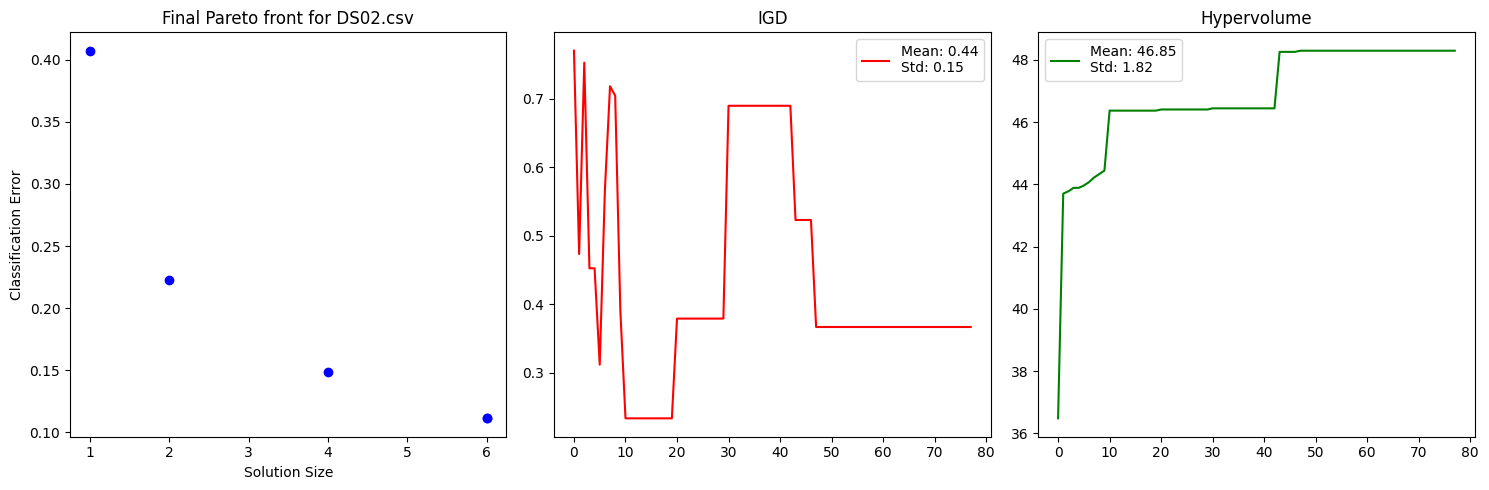

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS02.csv  |            74 |   46.2127 |  2.62129 |   0.484266 |  0.402844 |          1 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            78 |   45.8158 |  2.63565 |   0.566911 |  0.362877 |          1 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            86 |   46.7476 |  2.31041 |   0.392033 |  0.151255 |          1 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            48 |   44.8603 |  2.86441 |   0.466237 |  0.151142 |          1 |
+-----------+---------------+-----------+----------+------------+-----------+------------+

In [77]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std  = []
igd_std = []
generations = []
for _ in range(5):
    run_different_dataset(datasets[0])

doc = Document(document_path)
data = list(zip([datasets[0]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  56
Evaluations: 7000, HV: 48.25925925925926, IGD: 0.22258546689283795
No improvement in the last 30 generations. Stopping the algorithm.


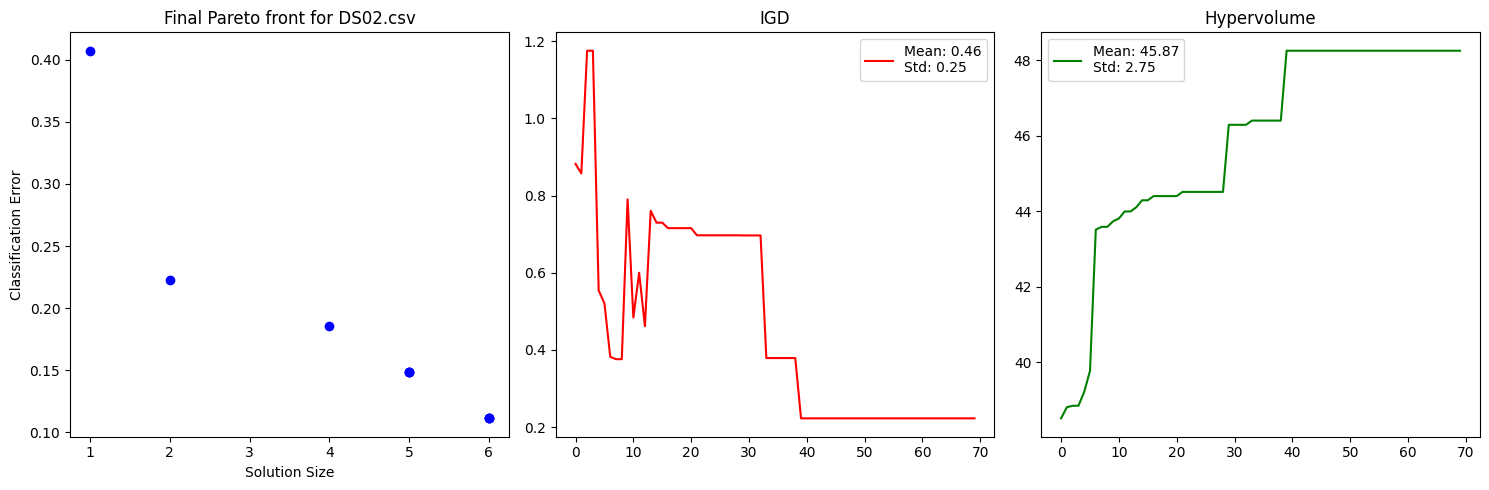

number of features:  56
Evaluations: 5400, HV: 46.4074074074074, IGD: 0.3788426751433336
No improvement in the last 30 generations. Stopping the algorithm.


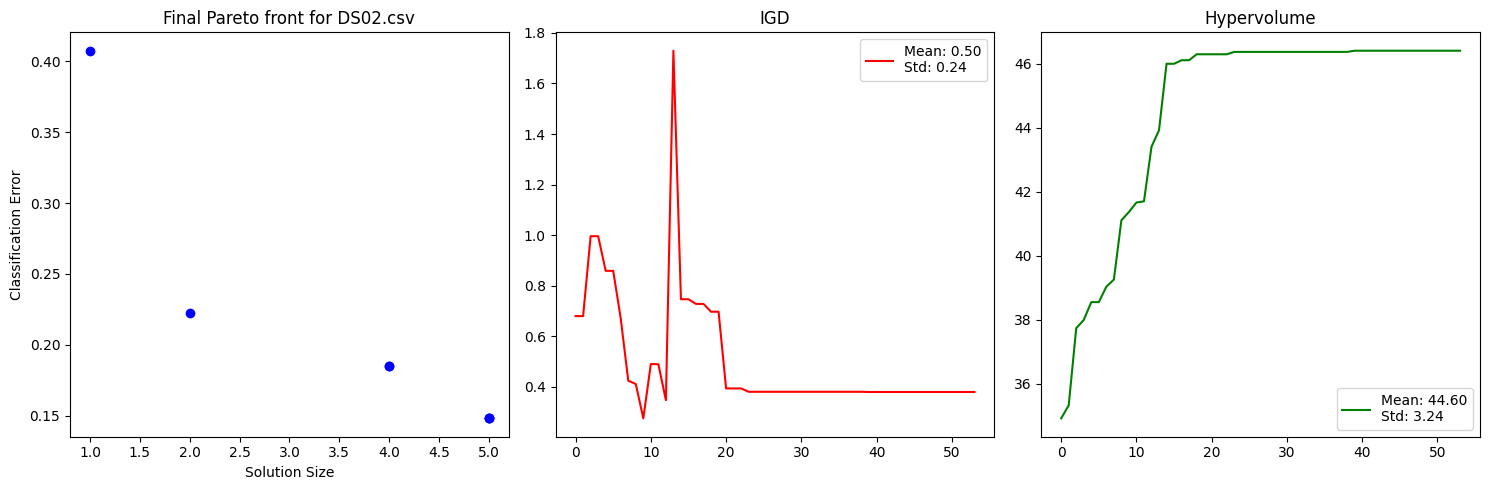

number of features:  56
Evaluations: 8900, HV: 48.25925925925926, IGD: 0.22258546689283795
No improvement in the last 30 generations. Stopping the algorithm.


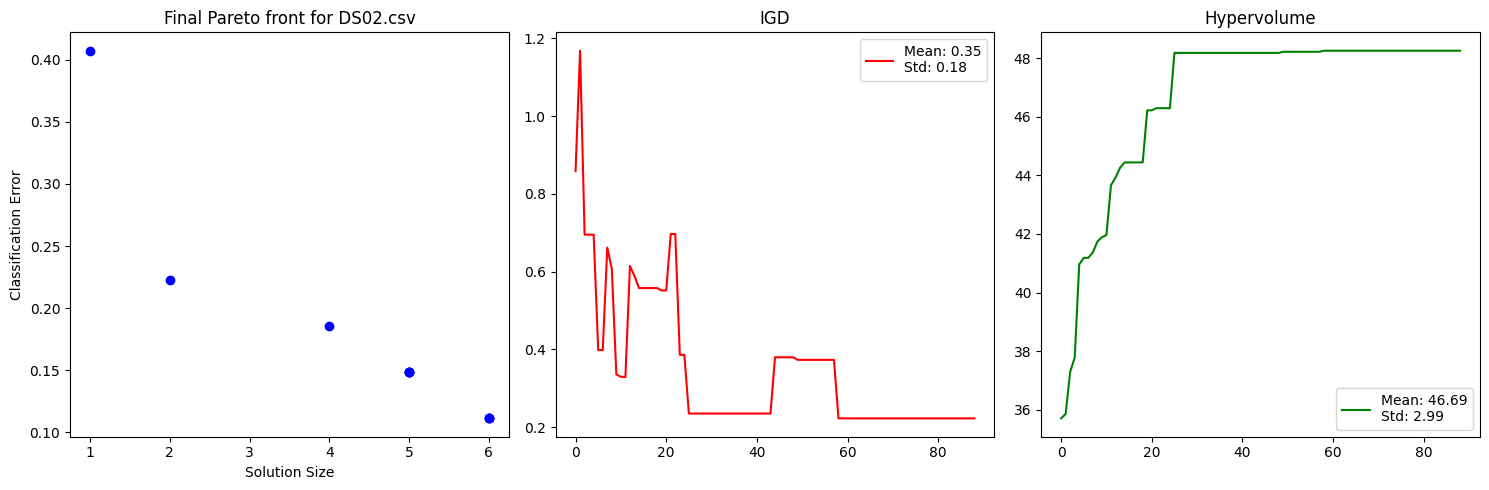

number of features:  56
Evaluations: 8600, HV: 48.25925925925926, IGD: 0.22258546689283795
No improvement in the last 30 generations. Stopping the algorithm.


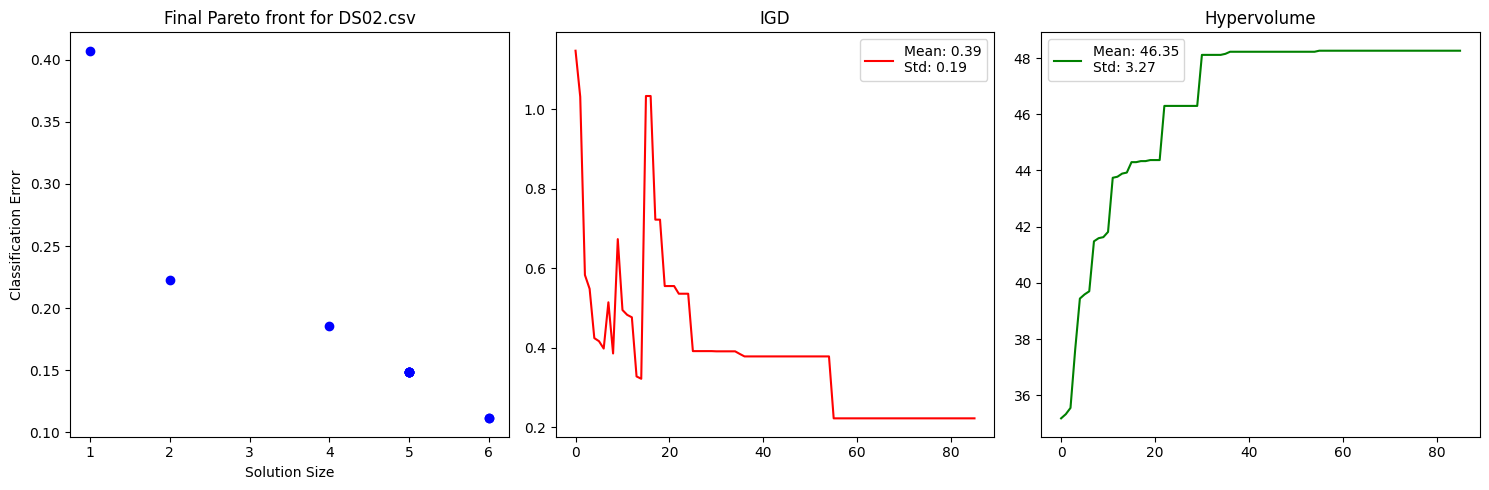

number of features:  56
Evaluations: 6400, HV: 48.14814814814815, IGD: 0.37884267514333353
No improvement in the last 30 generations. Stopping the algorithm.


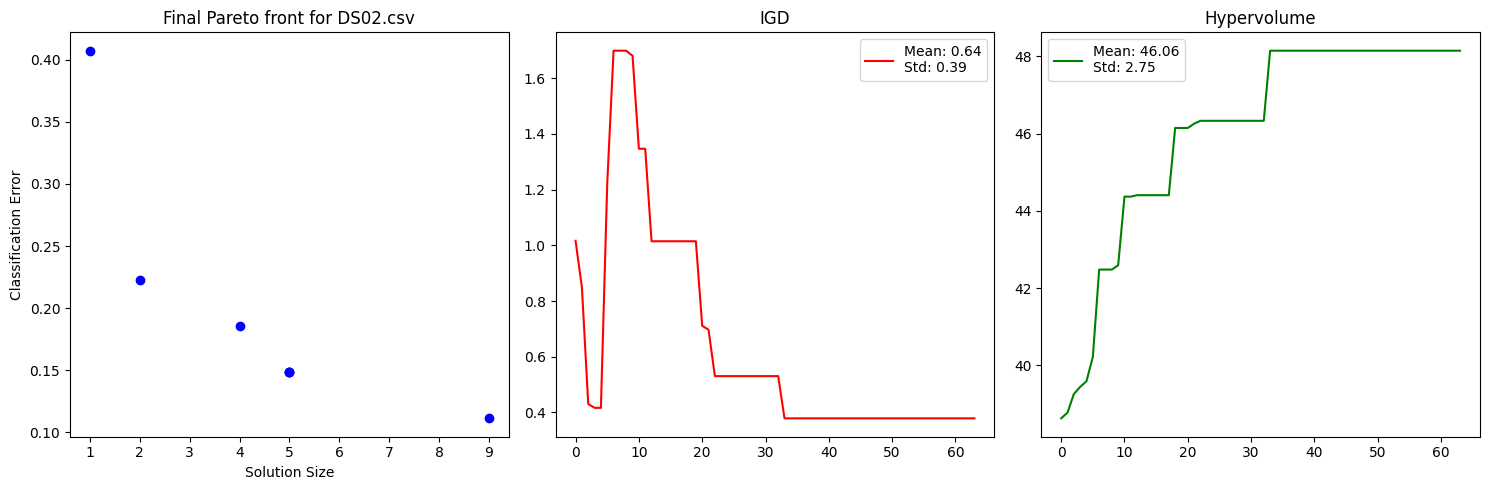

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS02.csv  |            70 |   45.8693 |  2.74661 |   0.456694 |  0.254774 |          2 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            54 |   44.5988 |  3.23781 |   0.503211 |  0.244547 |          1 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            89 |   46.6866 |  2.99346 |   0.348842 |  0.179997 |          2 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS02.csv  |            86 |   46.3488 |  3.266   |   0.388342 |  0.194258 |          2 |
+-----------+---------------+-----------+----------+------------+-----------+------------+

In [77]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std  = []
igd_std = []
generations = []
for _ in range(5):
    run_different_dataset(datasets[0])

doc = Document(document_path)
data = list(zip([datasets[0]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 100000, Hypervolume: 59.31214747681813
Evaluations: 200000, Hypervolume: 59.40911570252888
Evaluations: 300000, Hypervolume: 59.40911570252888


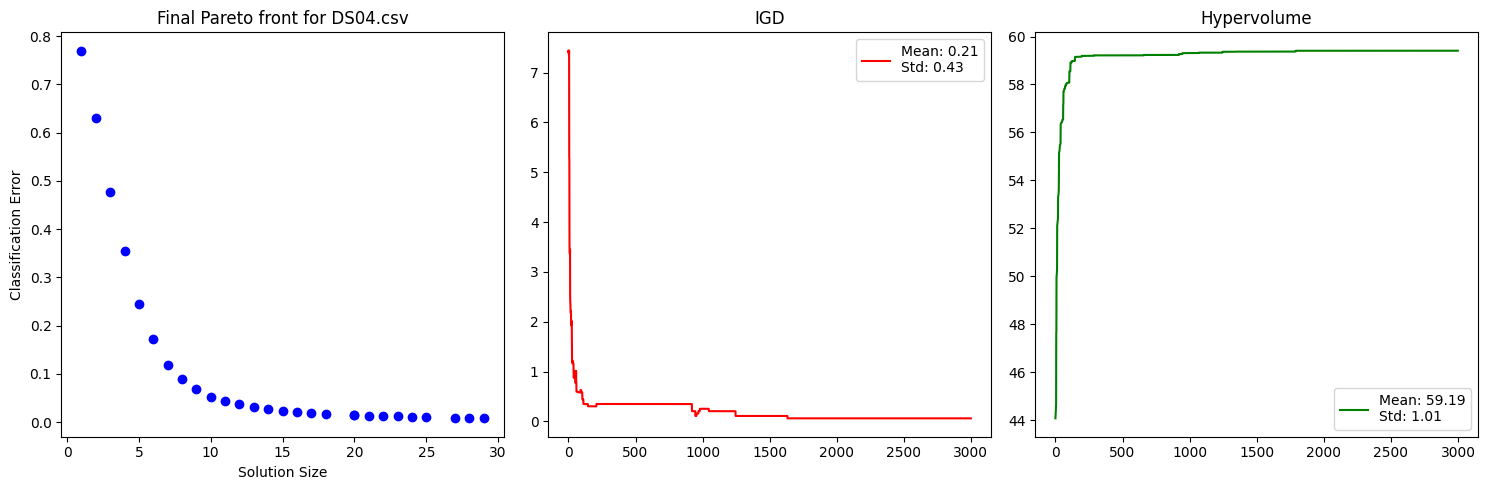

In [36]:
# random initialize
run_different_dataset(datasets[1])

In [33]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  64
Evaluations: 2500, HV: 58.38647030263797, IGD: 0.28224862806395407
Evaluations: 5000, HV: 58.979410548272824, IGD: 0.11905538180767491
Evaluations: 7500, HV: 59.10049870229511, IGD: 0.16253241618914765
Evaluations: 8500, HV: 59.17250184316052, IGD: 0.15914846681250272
No improvement in the last 40 generations. Stopping the algorithm.


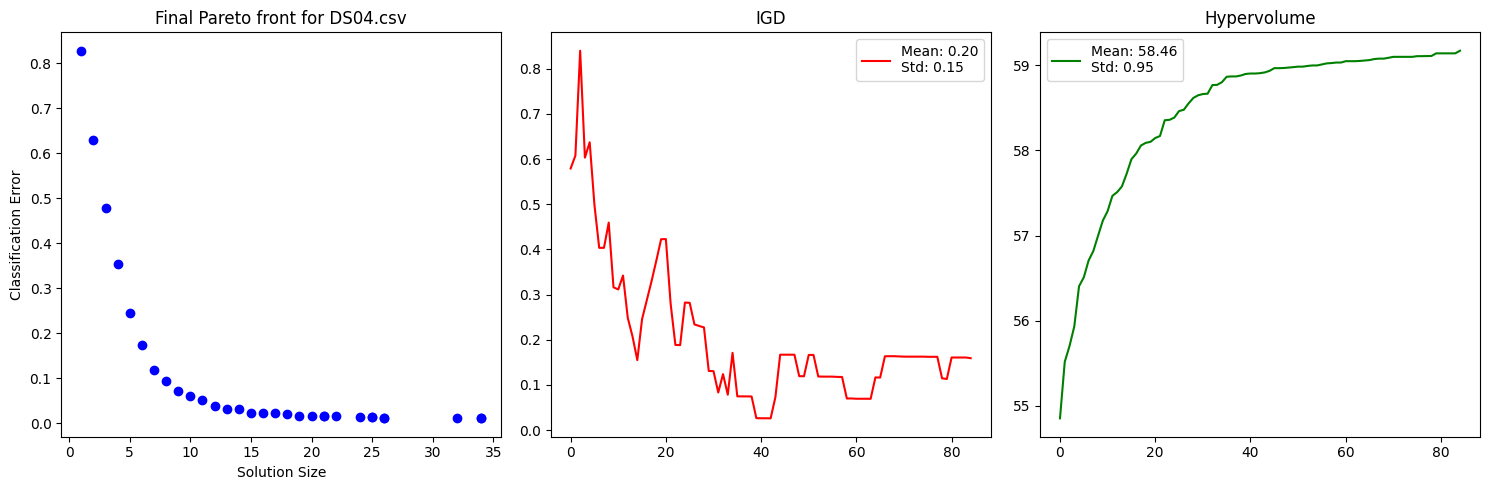

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04      |            85 |    58.465 | 0.945286 |   0.204455 |  0.153442 |         29 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [34]:
# wise initialization run 1
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip(["DS04"], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 2500, HV: 58.232418046789306, IGD: 0.287012151307644
Evaluations: 5000, HV: 58.927460394526264, IGD: 0.2153131849334206
Evaluations: 7500, HV: 59.159326991662326, IGD: 0.2075776771132428
Evaluations: 10000, HV: 59.20032008055961, IGD: 0.1112112490840915
No improvement in the last 40 generations. Stopping the algorithm.


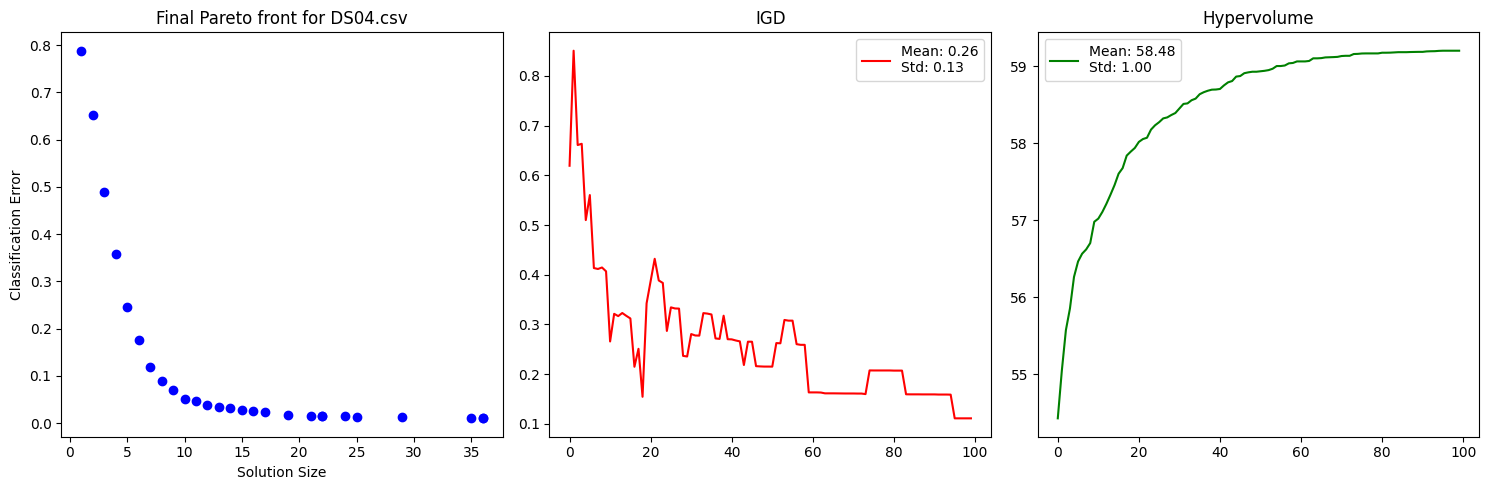

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04      |            85 |   58.465  | 0.945286 |   0.204455 |  0.153442 |         29 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS04      |           100 |   58.4846 | 0.995055 |   0.262293 |  0.12707  |         34 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [35]:
# wise initialization run 2
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip(["DS04"]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  64
Evaluations: 2500, HV: 58.29358999718282, IGD: 0.3765366183953595
Evaluations: 5000, HV: 58.903397409385434, IGD: 0.16952166503184735
Evaluations: 7500, HV: 59.087566608524696, IGD: 0.21161677245390076
Evaluations: 10000, HV: 59.148519777262294, IGD: 0.1616097611476406
Evaluations: 12500, HV: 59.2275748802695, IGD: 0.20580537853715106
Evaluations: 15000, HV: 59.245619871368376, IGD: 0.20520121032328104
Evaluations: 16400, HV: 59.24861388334442, IGD: 0.25268613166197906
No improvement in the last 40 generations. Stopping the algorithm.


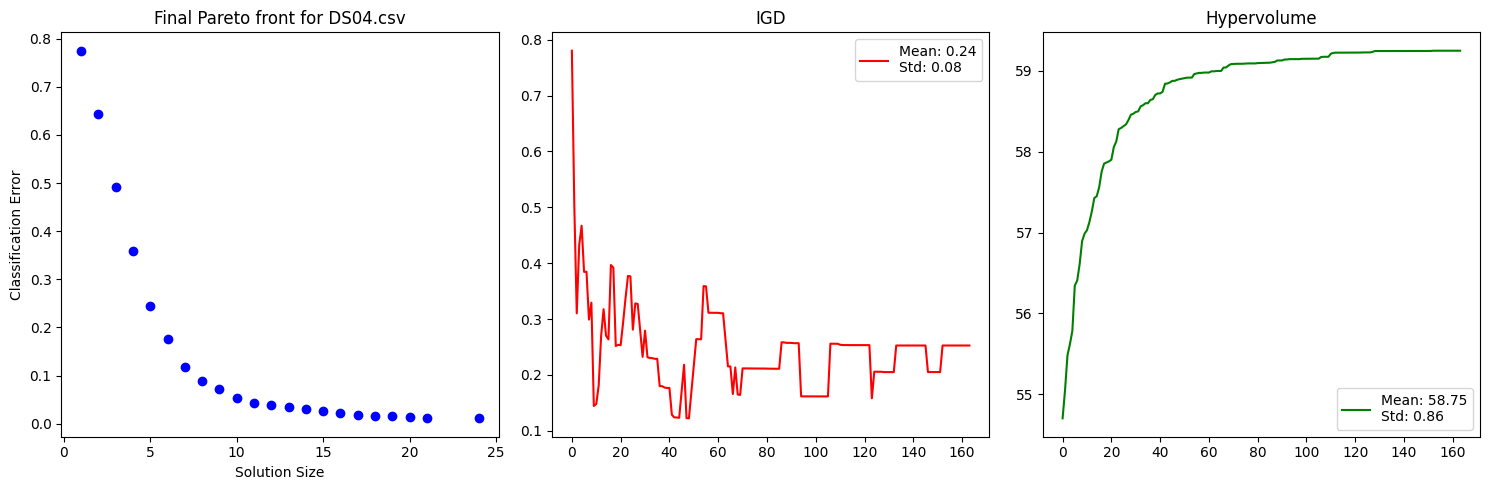

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS04      |            85 |   58.465  | 0.945286 |   0.204455 | 0.153442  |         29 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS04      |           100 |   58.4846 | 0.995055 |   0.262293 | 0.12707   |         34 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS04      |           164 |   58.7548 | 0.857002 |   0.244203 | 0.0768767 |         56 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [36]:
#wise initialization run 3
run_different_dataset(datasets[1])

doc = Document(document_path)
data = list(zip(["DS04"]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [ ]:
#wise initialization run 4
run_different_dataset(datasets[1])

doc = Document(document_path)
data = list(zip([datasets[1]]*4, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [ ]:
#wise initialization run 5
run_different_dataset(datasets[1])
doc = Document(document_path)
data = list(zip([datasets[1]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [82]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  500
Evaluations: 2500, HV: 416.6483333333333, IGD: 0.7556229416792869
Evaluations: 5000, HV: 437.4066666666667, IGD: 0.6193062373842908
Evaluations: 7500, HV: 451.345, IGD: 0.46786449058817775
Evaluations: 10000, HV: 452.275, IGD: 0.46617198148067474
Evaluations: 12500, HV: 453.08833333333337, IGD: 0.3233172752562849
Evaluations: 13000, HV: 453.08833333333337, IGD: 0.3233172752562849
No improvement in the last 20 generations. Stopping the algorithm.


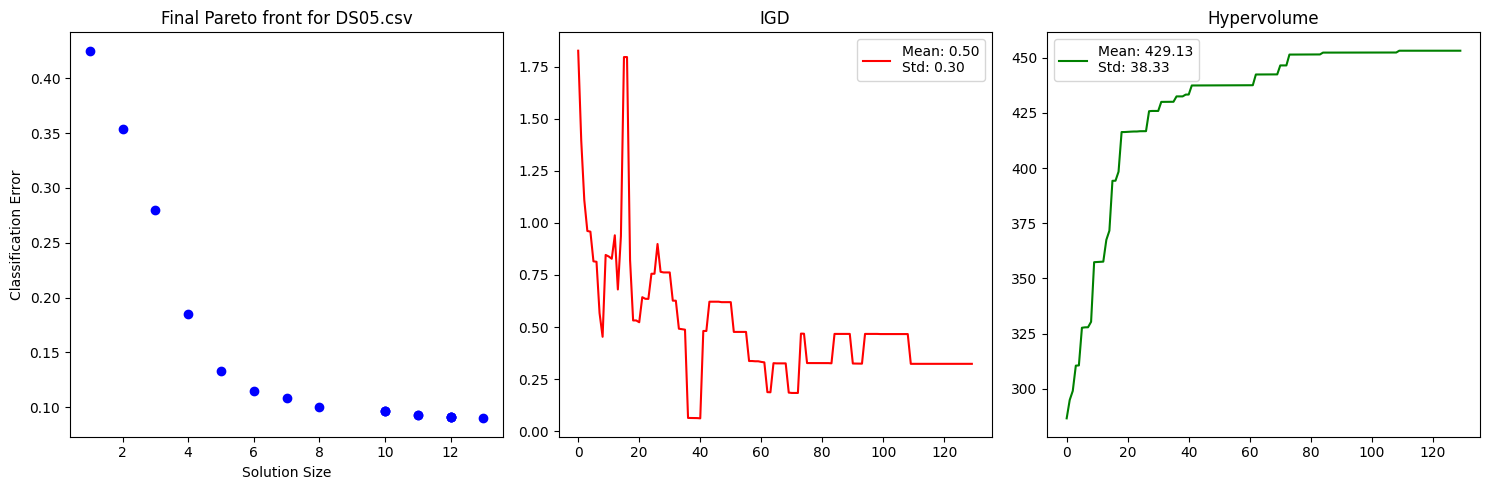

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS05.csv  |           130 |   429.131 |   38.327 |    0.50145 |  0.297278 |         17 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [83]:
#wise initialization run 1
run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  500
Evaluations: 2500, HV: 437.325, IGD: 0.9068367102462718
Evaluations: 5000, HV: 441.6, IGD: 0.7579695614044983
Evaluations: 7500, HV: 444.0916666666667, IGD: 0.6127299439662245
Evaluations: 10000, HV: 446.5233333333333, IGD: 0.32570350762319744
Evaluations: 12500, HV: 446.5333333333333, IGD: 0.4685558559411538
Evaluations: 15000, HV: 446.5483333333333, IGD: 0.46915716886491765
Evaluations: 17500, HV: 448.1716666666667, IGD: 0.4691564159030121
Evaluations: 20000, HV: 448.1716666666667, IGD: 0.1834435120652516
Evaluations: 22500, HV: 448.1716666666667, IGD: 0.3262998512741118
Evaluations: 25000, HV: 448.1716666666667, IGD: 0.4691564159030121
Evaluations: 27500, HV: 448.98, IGD: 0.18320448580285165
Evaluations: 30000, HV: 448.9816666666667, IGD: 0.3260612905210737


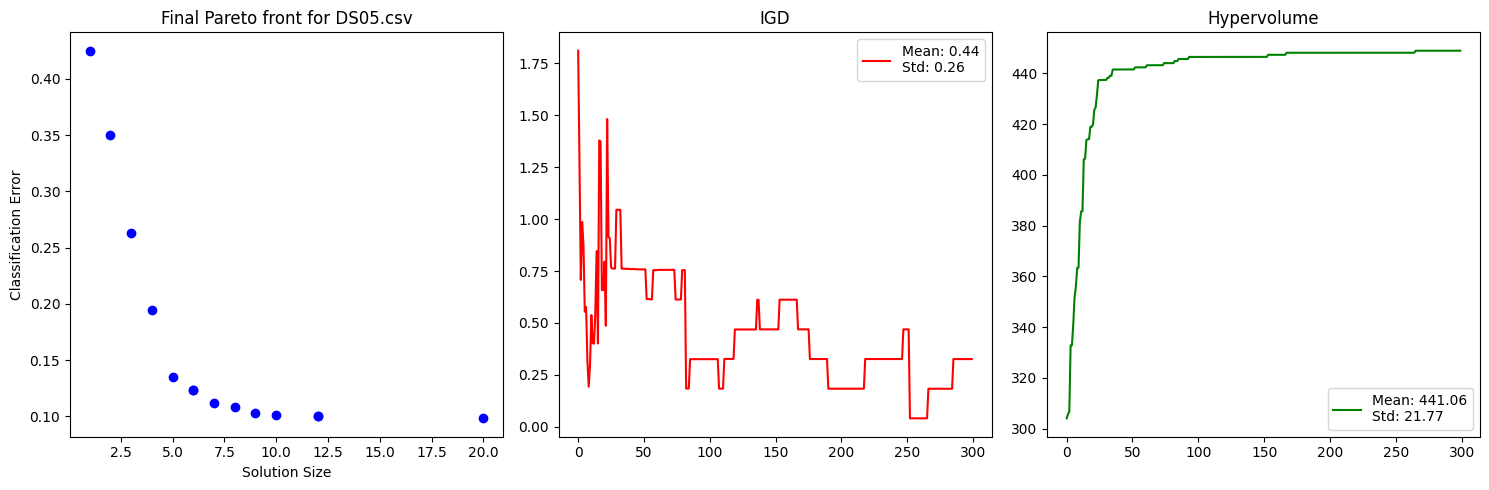

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS05.csv  |           130 |   429.131 |  38.327  |   0.50145  |  0.297278 |         17 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS05.csv  |           300 |   441.061 |  21.7655 |   0.442655 |  0.26107  |         38 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [85]:
#wise initialization run 2
run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  500
Evaluations: 2500, HV: 421.74, IGD: 1.6319794279596584
Evaluations: 5000, HV: 440.69000000000005, IGD: 0.33407784594931167
Evaluations: 7500, HV: 441.565, IGD: 0.18846113911276613
Evaluations: 10000, HV: 441.5783333333334, IGD: 0.47368641183394383
Evaluations: 12500, HV: 443.2083333333333, IGD: 0.18773983337752598
Evaluations: 15000, HV: 443.2133333333333, IGD: 0.4734459763599211
Evaluations: 17200, HV: 443.2183333333333, IGD: 0.47273169064563536
No improvement in the last 30 generations. Stopping the algorithm.


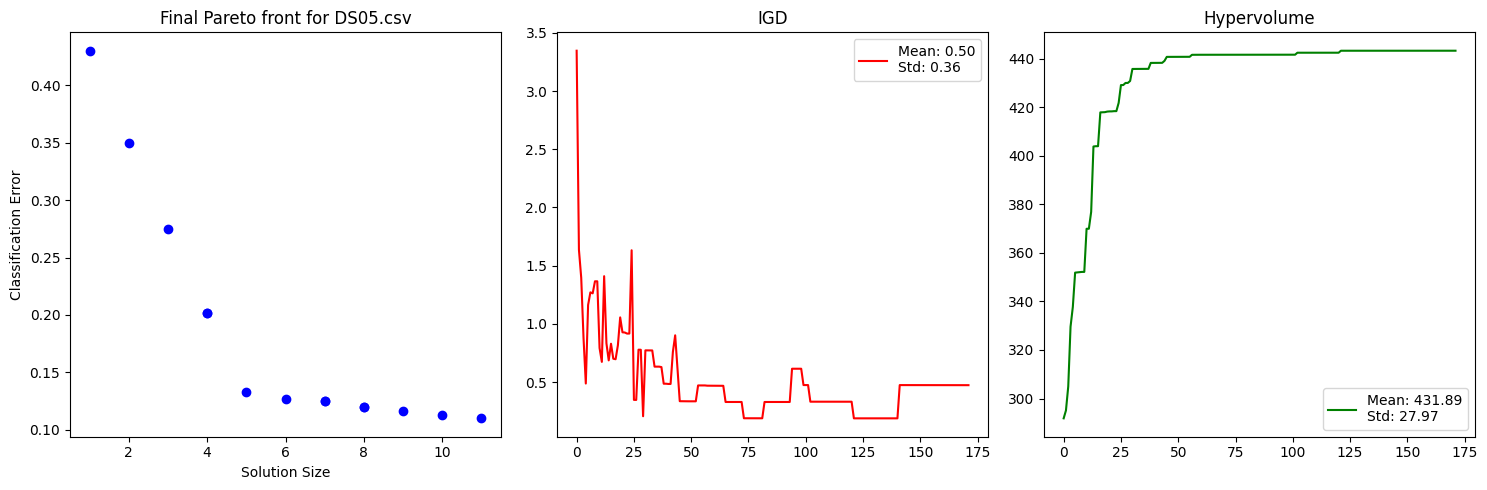

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS05.csv  |           130 |   429.131 |  38.327  |   0.50145  |  0.297278 |         17 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS05.csv  |           300 |   441.061 |  21.7655 |   0.442655 |  0.26107  |         38 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS05.csv  |           172 |   431.894 |  27.9747 |   0.50006  |  0.360041 |         22 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [86]:
#wise initialization run 3
run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*3, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [ ]:
#wise initialization run 4
run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*4, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [ ]:
#wise initialization run 5
run_different_dataset(datasets[2])

doc = Document(document_path)
data = list(zip([datasets[2]]*5, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

In [89]:
elapsed_times = []
hv_mean = []
igd_mean = []
hv_std = []
igd_std = []
generations = []

number of features:  561
Evaluations: 100000, HV: 542.0255555555556, IGD: 2.4288419141085584
Evaluations: 200000, HV: 548.6122222222222, IGD: 0.18200412428615262
Evaluations: 300000, HV: 549.2444444444444, IGD: 0.17772037702437637


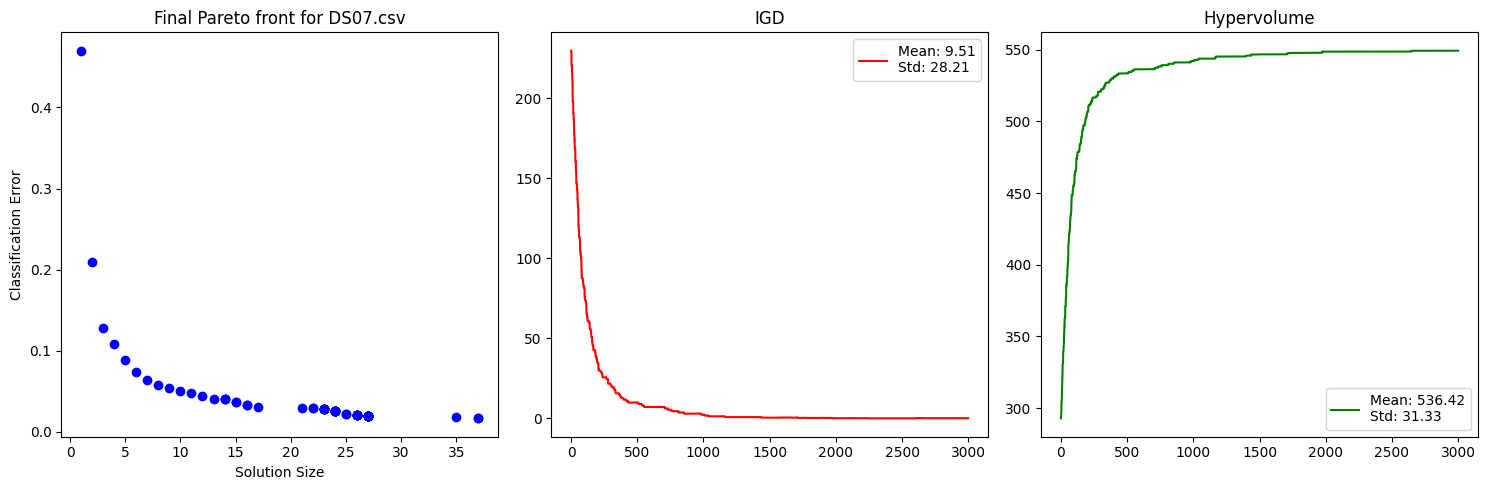

In [18]:
# random initialize
run_different_dataset(datasets[3])

number of features:  561
Evaluations: 2500, HV: 526.1577777777778, IGD: 0.3541974668177832
Evaluations: 3700, HV: 526.7055555555555, IGD: 0.27394007100708645
No improvement in the last 30 generations. Stopping the algorithm.


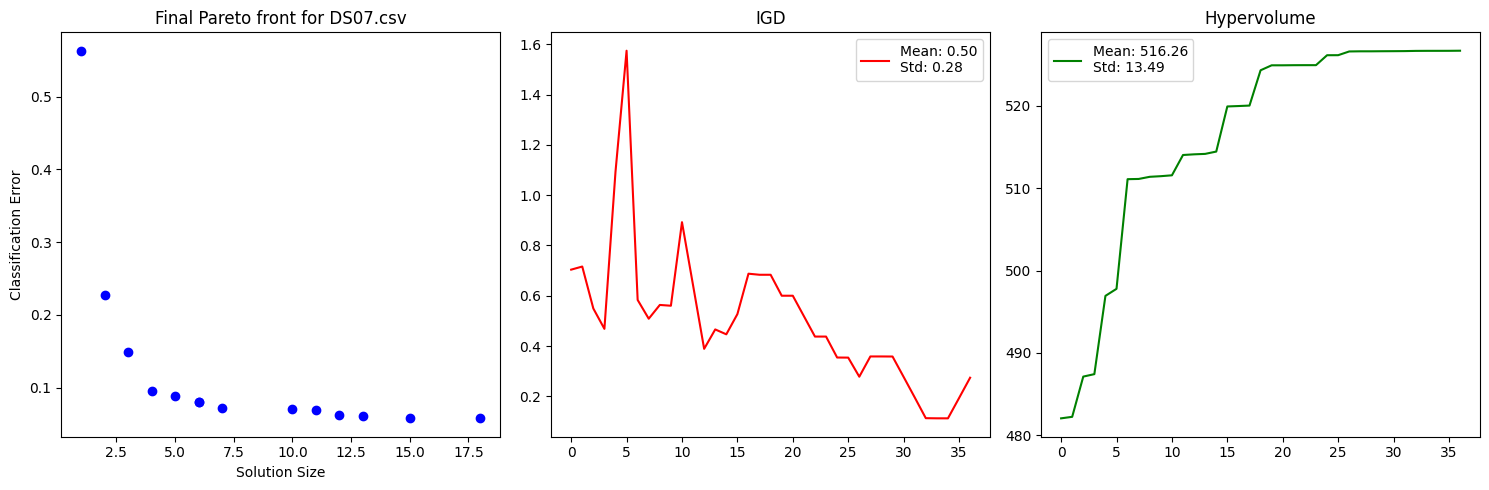

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |            37 |   516.259 |  13.4904 |   0.504484 |  0.276155 |          7 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [90]:
# wise intilization run 1
run_different_dataset(datasets[3])

doc = Document(document_path)
data = list(zip([datasets[3]], generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  561
Evaluations: 2500, HV: 523.6377777777778, IGD: 0.6883392586112329
Evaluations: 5000, HV: 529.8866666666668, IGD: 0.4339990034024035
Evaluations: 7500, HV: 534.1988888888889, IGD: 0.5959361735076764
Evaluations: 9500, HV: 534.8411111111111, IGD: 0.5118092952516505
No improvement in the last 30 generations. Stopping the algorithm.


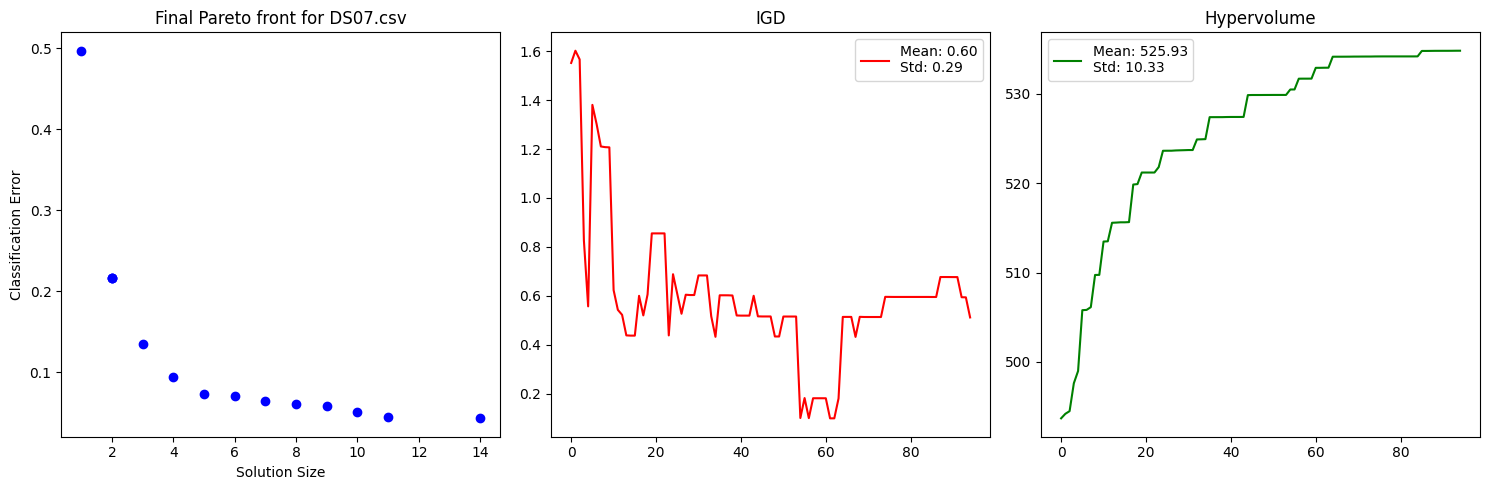

+-----------+---------------+-----------+----------+------------+-----------+------------+
| Dataset   |   generation# |   HV_mean |   HV_std |   IGD_mean |   IGD_std |   Duration |
+===========+===============+===========+==========+============+===========+============+
| DS07.csv  |            37 |   516.259 |  13.4904 |   0.504484 |  0.276155 |          7 |
+-----------+---------------+-----------+----------+------------+-----------+------------+
| DS07.csv  |            95 |   525.929 |  10.3259 |   0.600894 |  0.28794  |         19 |
+-----------+---------------+-----------+----------+------------+-----------+------------+


In [95]:
# wise intilization run 2
run_different_dataset(datasets[3])

doc = Document(document_path)
data = list(zip([datasets[3]]*2, generations, hv_mean, hv_std, igd_mean, igd_std, elapsed_times))
table = tabulate(data, headers=['Dataset','generation#', 'HV_mean', 'HV_std','IGD_mean','IGD_std' ,'Duration'], tablefmt='grid')
doc.add_paragraph(table)
print(table)
doc.save(document_path)

number of features:  649
Evaluations: 25000, HV: 591.9554824285364, IGD: 26.928896199185708
Evaluations: 50000, HV: 609.0753687819556, IGD: 14.073136268640786
Evaluations: 75000, HV: 615.8413743084402, IGD: 8.64583942329659
Evaluations: 100000, HV: 621.4474144803486, IGD: 5.086199016790782


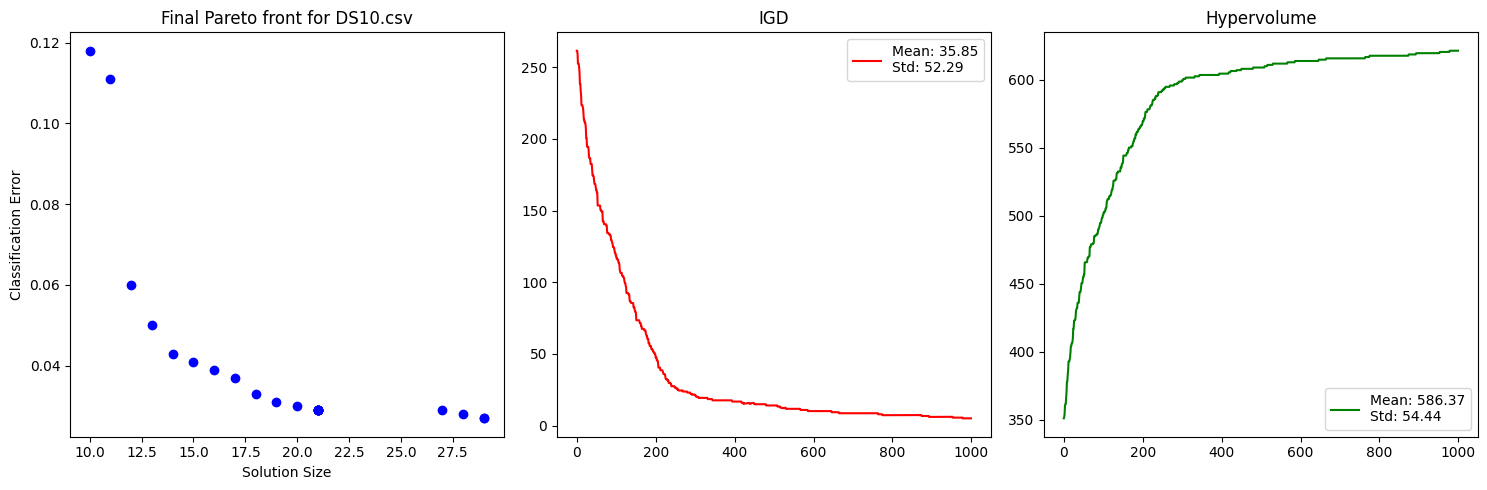

In [24]:
#random initialization
run_different_dataset(datasets[5])